# Daily Risk between 2 countries

In [1]:
import sys
import sqlalchemy
import config
import pandas as pd
import art
import psycopg2
import jupyterlab
import ipywidgets
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
from dbcontext import Context
from jupyter_service import JupyterService
art.tprint(config.name, "big")
print(sys.version, config.version, jupyterlab.__version__, plotly.__version__, ipywidgets.__version__)

 _____   _____   _____  _____   _____ 
|_   _| / ____| / ____||  __ \ |_   _|
  | |  | (___  | |     | |__) |  | |  
  | |   \___ \ | |     |  _  /   | |  
 _| |_  ____) || |____ | | \ \  _| |_ 
|_____||_____/  \_____||_|  \_\|_____|
                                      
                                      

3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)] 0.1.0.RC1 4.2.5 5.24.1 8.1.5


In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:.2f}'.format)
print(config.connection_string)
context = Context()
context.create(echo=False)
service = JupyterService(context)

postgresql://postgres:sa@localhost:5432/iscri


In [13]:
actor1_code='RUS'
actor2_code='UKR'
start_date='2022-01-01'
end_date='2024-09-30'
window=30
df = service.get_risks_by_dates_codes(start_date, end_date, actor1_code=actor1_code, actor2_code=actor2_code)
df["risk3"] = df.quad3_nb / df.total_nb
df["risk4"] = df.quad4_nb / df.total_nb
df["risk"] = df.risk3 + df.risk4
df["risk_g3"] = df.goldstein_quad3_nb / df.total_nb
df["risk_g4"] = df.goldstein_quad4_nb / df.total_nb
df["risk_g34"] = df.risk_g3 + df.risk_g4
df["risk_g"] = df.goldstein_nb / df.total_nb
df["mobile"] = df.risk.rolling(window).mean()
df["mobile3"] = df.risk3.rolling(window).mean()
df["mobile4"] = df.risk4.rolling(window).mean()
df["conv"] = service.savgol(df.risk, window, 3, "nearest")
df["conv3"] = service.savgol(df.risk3, window, 3)
df["conv4"] = service.savgol(df.risk4, window, 3)
df

SELECT * FROM daily_risk WHERE date >= '2022-01-01' AND date <= '2024-09-30' AND actor1_code = 'RUS' AND actor2_code = 'UKR'


,id,date,actor1_code,actor2_code,quad3_nb,quad4_nb,total_nb,goldstein_nb,goldstein_quad3_nb,goldstein_quad4_nb,compute_date,risk3,risk4,risk,risk_g3,risk_g4,risk_g34,risk_g,mobile,mobile3,mobile4,conv,conv3,conv4
0,1250136,2022-01-02,RUS,UKR,0,5,9,5,0,5,2024-11-14 20:14:37.390068,0.00,0.56,0.56,0.00,0.56,0.56,0.56,NaN,NaN,NaN,0.49,0.06,0.43
1,1250208,2022-01-03,RUS,UKR,1,0,8,1,1,0,2024-11-14 20:14:37.537144,0.12,0.00,0.12,0.12,0.00,0.12,0.12,NaN,NaN,NaN,0.48,0.07,0.41
2,1250408,2022-01-04,RUS,UKR,1,2,4,3,1,2,2024-11-14 20:14:37.709880,0.25,0.50,0.75,0.25,0.50,0.75,0.75,NaN,NaN,NaN,0.47,0.08,0.39
3,1250582,2022-01-05,RUS,UKR,0,1,8,3,0,1,2024-11-14 20:14:37.867926,0.00,0.12,0.12,0.00,0.12,0.12,0.38,NaN,NaN,NaN,0.46,0.09,0.36
4,1250716,2022-01-06,RUS,UKR,1,0,3,1,1,0,2024-11-14 20:14:38.016552,0.33,0.00,0.33,0.33,0.00,0.33,0.33,NaN,NaN,NaN,0.44,0.10,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,1405643,2024-09-26,RUS,UKR,9,5,43,15,9,5,2024-11-14 20:17:50.421349,0.21,0.12,0.33,0.21,0.12,0.33,0.35,0.51,0.24,0.26,0.51,0.17,0.35
992,1405816,2024-09-27,RUS,UKR,6,4,34,13,6,4,2024-11-14 20:17:50.653944,0.18,0.12,0.29,0.18,0.12,0.29,0.38,0.50,0.24,0.26,0.52,0.15,0.36
993,1406049,2024-09-28,RUS,UKR,4,6,15,10,4,6,2024-11-14 20:17:50.784470,0.27,0.40,0.67,0.27,0.40,0.67,0.67,0.50,0.24,0.26,0.52,0.15,0.37
994,1406144,2024-09-29,RUS,UKR,2,5,13,7,2,5,2024-11-14 20:17:50.893552,0.15,0.38,0.54,0.15,0.38,0.54,0.54,0.51,0.24,0.27,0.51,0.15,0.36


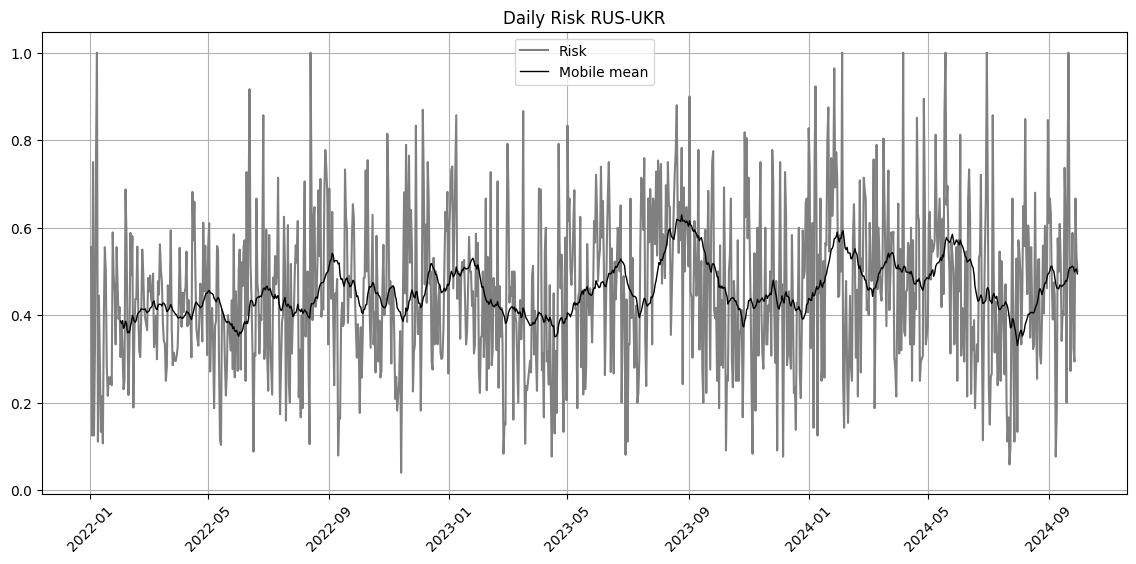

In [14]:
plt.figure(figsize=(14,6))
plt.xticks(rotation=45)
plt.grid()
plt.plot(df.date, df.risk, color="grey", label="Risk")
plt.plot(df.date, df.mobile, color="black", linewidth=1, label="Mobile mean")
# plt.plot(df.date, df.conv, color="red", linewidth=1, label="Convolution")
plt.title(f"Daily Risk {actor1_code}-{actor2_code}")
plt.legend()
plt.savefig("data/daily_risk.png")
# plt.ylim(1.4,1.8)

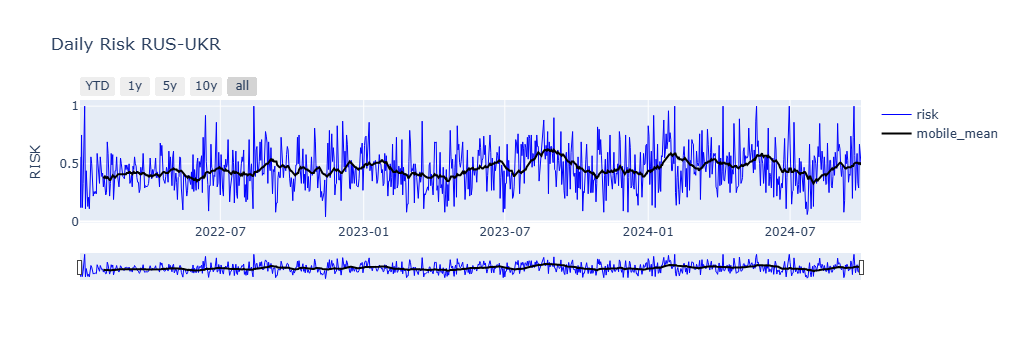

In [15]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df.date,
        y=np.round(df.risk, 2),
        name="risk",
        line=dict(color="#0000ff", width=1),
    )
)

fig.add_trace(
    go.Scatter(
        x=df.date,
        y=np.round(df.mobile, 2),
        name="mobile_mean",
        line=dict(color="#000000", width=2),
    )
)

# Set title
fig.update_layout(
    height=600,
    title=f"Daily Risk {actor1_code}-{actor2_code}",
    yaxis_title="RISK",
    xaxis=dict(tickformat="%Y-%m")
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=5,
                     label="5y",
                     step="year",
                     stepmode="backward"),
                dict(count=10,
                     label="10y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ]),
            
        ),
        rangeslider=dict(
            visible=True,
        ),
        type="date"
    )
)

fig.write_html("data/daily_risk.html")
fig.show()

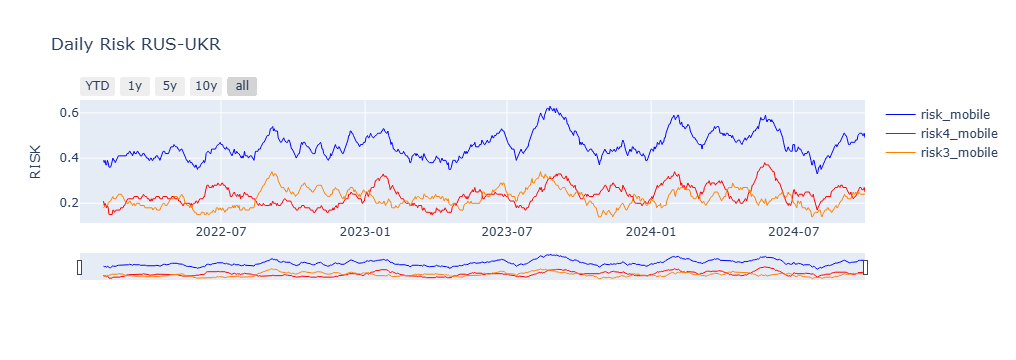

In [16]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df.date,
        y=np.round(df.mobile, 2),
        name="risk_mobile",
        line=dict(color="#0000ff", width=1),
    )
)

fig.add_trace(
    go.Scatter(
        x=df.date,
        y=np.round(df.mobile4, 2),
        name="risk4_mobile",
        line=dict(color="#ff0000", width=1),
    )
)

fig.add_trace(
    go.Scatter(
        x=df.date,
        y=np.round(df.mobile3, 2),
        name="risk3_mobile",
        line=dict(color="#ff8000", width=1),
    )
)

# Set title
fig.update_layout(
    height=600,
    title=f"Daily Risk {actor1_code}-{actor2_code}",
    yaxis_title="RISK",
    xaxis=dict(tickformat="%Y-%m")
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=5,
                     label="5y",
                     step="year",
                     stepmode="backward"),
                dict(count=10,
                     label="10y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ]),
            
        ),
        rangeslider=dict(
            visible=True,
        ),
        type="date"
    )
)

fig.write_html("data/daily_risk_x3.html")
fig.show()

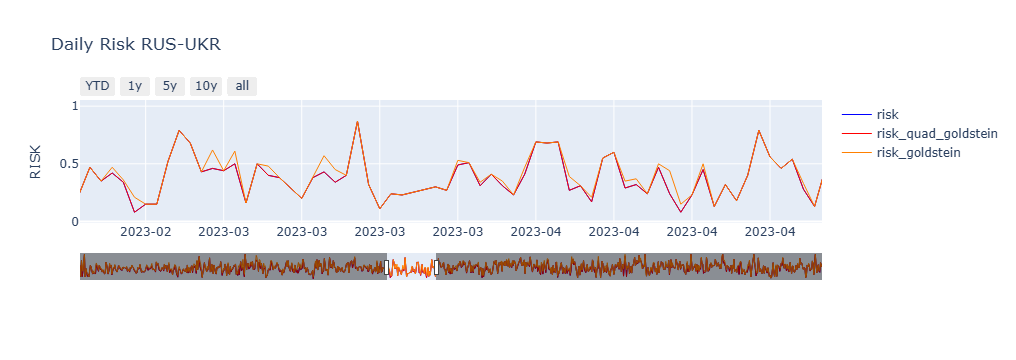

In [12]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df.date,
        y=np.round(df.risk, 2),
        name="risk",
        line=dict(color="#0000ff", width=1),
    )
)

fig.add_trace(
    go.Scatter(
        x=df.date,
        y=np.round(df.risk_g34, 2),
        name="risk_quad_goldstein",
        line=dict(color="#ff0000", width=1),
    )
)

fig.add_trace(
    go.Scatter(
        x=df.date,
        y=np.round(df.risk_g, 2),
        name="risk_goldstein",
        line=dict(color="#ff8000", width=1),
    )
)

# Set title
fig.update_layout(
    height=600,
    title=f"Daily Risk {actor1_code}-{actor2_code}",
    yaxis_title="RISK",
    xaxis=dict(tickformat="%Y-%m")
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=5,
                     label="5y",
                     step="year",
                     stepmode="backward"),
                dict(count=10,
                     label="10y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ]),
            
        ),
        rangeslider=dict(
            visible=True,
        ),
        type="date"
    )
)

fig.write_html("data/daily_risk_x3.html")
fig.show()